In [1]:
import torch
from torch import nn
import torchvision.datasets as datasets 
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from model import *

Download/loading the dataset

In [2]:
training_data = datasets.MNIST(root='data', download=True, train=True, transform=ToTensor())
testing_data = datasets.MNIST(root='data', download=True, train=False, transform=ToTensor())

training_loader = DataLoader(training_data, batch_size=64, shuffle=True)
testing_loader = DataLoader(testing_data, batch_size=64, shuffle=True)

Displaying a few sample images

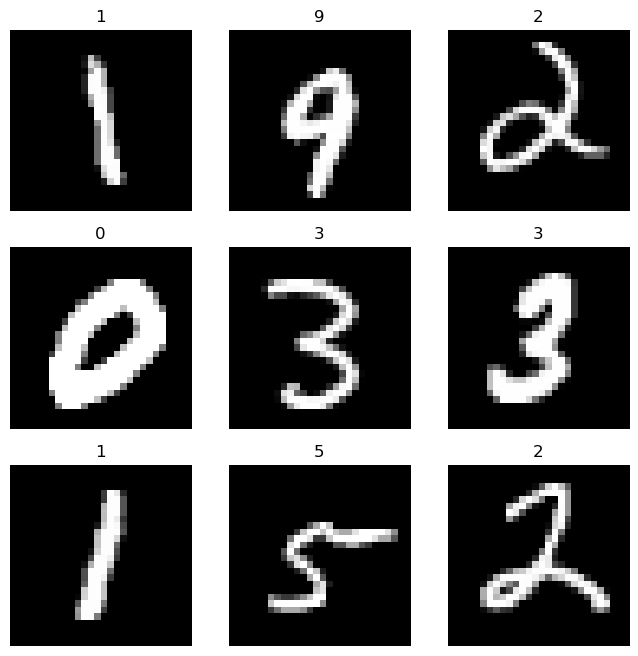

In [3]:
figure = plt.figure(figsize = (8,8))
rows, cols = 3, 3

for i in range(1, cols*rows+1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(label)
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")

## Training the neural network

In [4]:
device = (    
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
  )

Getting a random sample and making a prediction before training

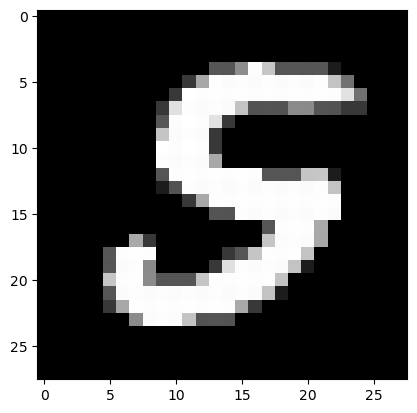

In [5]:
sample_idx = torch.randint(len(training_data), size=(1,)).item()
img, label = training_data[sample_idx]
plt.imshow(img.squeeze(), cmap="gray")

In [6]:
model = MnistClassifier().to(device)

output = model(img)
pred_probab = nn.Softmax(dim=1)(output)
y_pred = pred_probab.argmax(1)
print("Prediction: ", y_pred)
print("Actual: ",label)

Prediction:  tensor([8])
Actual:  5


Trying to add ReLU to introduce non-linearity

In [7]:
non_linear_model = NonLinearClassifier().to(device)

output = non_linear_model(img)
pred_probab = nn.Softmax(dim=1)(output)
y_pred = pred_probab.argmax(1)
print("Prediction: ", y_pred)
print("Actual: ",label)

Prediction:  tensor([6])
Actual:  5


Comparing both models for 50 images

In [8]:
linear_accuracy = 0
non_linear_accuracy = 0

for i in range(0, 50):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[sample_idx]
  output = model(img)
  pred_probab = nn.Softmax(dim=1)(output)
  y_pred = pred_probab.argmax(1)
  if y_pred == label:
    linear_accuracy += 1

  output = non_linear_model(img)
  pred_probab = nn.Softmax(dim=1)(output)
  y_pred = pred_probab.argmax(1)
  if y_pred == label:
    non_linear_accuracy += 1

print("Linear Accuracy: ", linear_accuracy)
print("Non Linear Accuracy: ", non_linear_accuracy)

Linear Accuracy:  6
Non Linear Accuracy:  5


In [9]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

In [10]:
def train(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")    
    

In [11]:
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [12]:
epochs = 5
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train(training_loader, model, loss_fn, optimizer)
  test(testing_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.308445  [    0/60000]
loss: 2.311530  [ 6400/60000]
loss: 2.266015  [12800/60000]
loss: 2.265328  [19200/60000]
loss: 2.258112  [25600/60000]
loss: 2.231327  [32000/60000]
loss: 2.222828  [38400/60000]
loss: 2.212873  [44800/60000]
loss: 2.187019  [51200/60000]
loss: 2.190948  [57600/60000]
Test Error: 
 Accuracy: 46.7%, Avg loss: 2.168646 

Epoch 2
-------------------------------
loss: 2.172957  [    0/60000]
loss: 2.170202  [ 6400/60000]
loss: 2.135433  [12800/60000]
loss: 2.134197  [19200/60000]
loss: 2.078261  [25600/60000]
loss: 2.113196  [32000/60000]
loss: 2.068382  [38400/60000]
loss: 2.039151  [44800/60000]
loss: 1.996544  [51200/60000]
loss: 2.056451  [57600/60000]
Test Error: 
 Accuracy: 61.6%, Avg loss: 1.986251 

Epoch 3
-------------------------------
loss: 1.954653  [    0/60000]
loss: 1.924805  [ 6400/60000]
loss: 1.884051  [12800/60000]
loss: 1.868281  [19200/60000]
loss: 1.891182  [25600/60000]
loss: 1.800038  [32000/600